### Tutorial 10

We will continue with the example of [section 6.3](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/6%20Modeling%20stoichiometry%20variations/Oxygen%20starvation%20in%20batch%20fermenters.ipynb). Below the physiological properties of the microbe as given before:

|$\alpha \qquad \qquad$|$\gamma \qquad \qquad $|$\mu_{max} \qquad$|$\theta_{max}\qquad$| $(P/O)$ $\qquad \qquad$
|----|-|-|-|-
|$\frac{cmol\,CO_2}{cmol \, X}$|$\frac{mol \, ATP}{Cmol \, X}$|$\frac{1}{h}$|$\frac{mol \, ATP}{cmol\,X\cdot h}$|$\frac{mol\,ATP}{mol\, O}$
|0.1|2.5|0.3|0.1|1.5

The biomass formula is given by $CH_{1.8}O_{0.5}N_{0.2}$

The following Monod characteristics are known:

|$K_M\left[\frac{mg}{L} \right] \qquad$ |
 -|-
 **Growth**|30 
**Maintenance**|5 

Since only $CO_2$ will be formed as product, zero product inhibition is present. The following conditions are specified for the batch fermenter:

|V [$L$]|$C_X^o \left[ \frac{g}{L}\right]$|$C_S^o \left[ \frac{g}{L}\right]$
|-------------|-------|------
|2000|0.025 $\qquad$|150 $\qquad$

We can now define the parameters:

In [131]:
import numpy
import matplotlib.pyplot as plt
%matplotlib notebook 
from scipy.integrate import odeint
alpha, gamma, mu_max, theta_max, PO = 0.1, 2.5, 0.3, 0.1, 1.5
Km_mu, Km_theta = 30/1000/30, 5/1000/30
Mx=12+1.8+0.5*16+0.2*14
V, Cxo, Cso = 200, 0.025/Mx, 150/30

We can also define $k_La$ and $C_{O_2}^{sat}$ as 200$\frac{1}{h}$ and 7$\frac{mg}{L}$: 

In [132]:
kla=200
Co_s_max=7/1000/32  #mol/l maximum oxygen concentration

The flux model is given below. Note that carbon splits between biomass and respiration.

<img src="respv2.png" width="700" />

In [133]:
def response_fun(C):
    
    Cx, Cs = C          
    mu=mu_max*Cs/(Km_mu+Cs)
    theta=theta_max*Cs/(Km_theta+Cs)
    
    ro_mt=kla*Co_s_max
    
    Sbase = numpy.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                         [0,0.1,1,0,-1],
                         [0,0.1,2,-2,0],
                         [0,-2.5,2/3,3,0]])
    
    S1 = numpy.vstack([Sbase,[0,1,0,0,0]])  #Stoich matrix with growth spec
      
    C = numpy.matrix([[0,0,0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)            #rates for regime where no oxygen limitation exist
    
        
    if ro_mt > r[3,0]*Cx:     #no oxygen limitation
        
        return [r[1,0],      #biomass 
                -r[0,0],
                r[4,0],      # CO2 formation
                r[3,0],]      # O2 consumption                                                 
                
    else:
        
        S2 = numpy.vstack([Sbase,[0,0,0,1,0]])          #Stoich matrix with oxygen spec

        C2= numpy.matrix([[0,0,0,theta,ro_mt/Cx]]).T   # Note the ro specification!!
        r2 = numpy.linalg.solve(S2,C2)                 # rates for regime where oxygen limitation exist
        
        
        return [r2[1,0],
                -r2[0,0],
                r2[4,0],    #CO2 formation
                r2[3,0]]    #O2 consumption 
                 

In [134]:
def ferm_eq(C,t):
    Cx, Cs = C[0],C[1]
    r=response_fun([Cx, Cs])     
    
    return [r[0]*Cx,
            r[1]*Cx]    
            

<IPython.core.display.Javascript object>


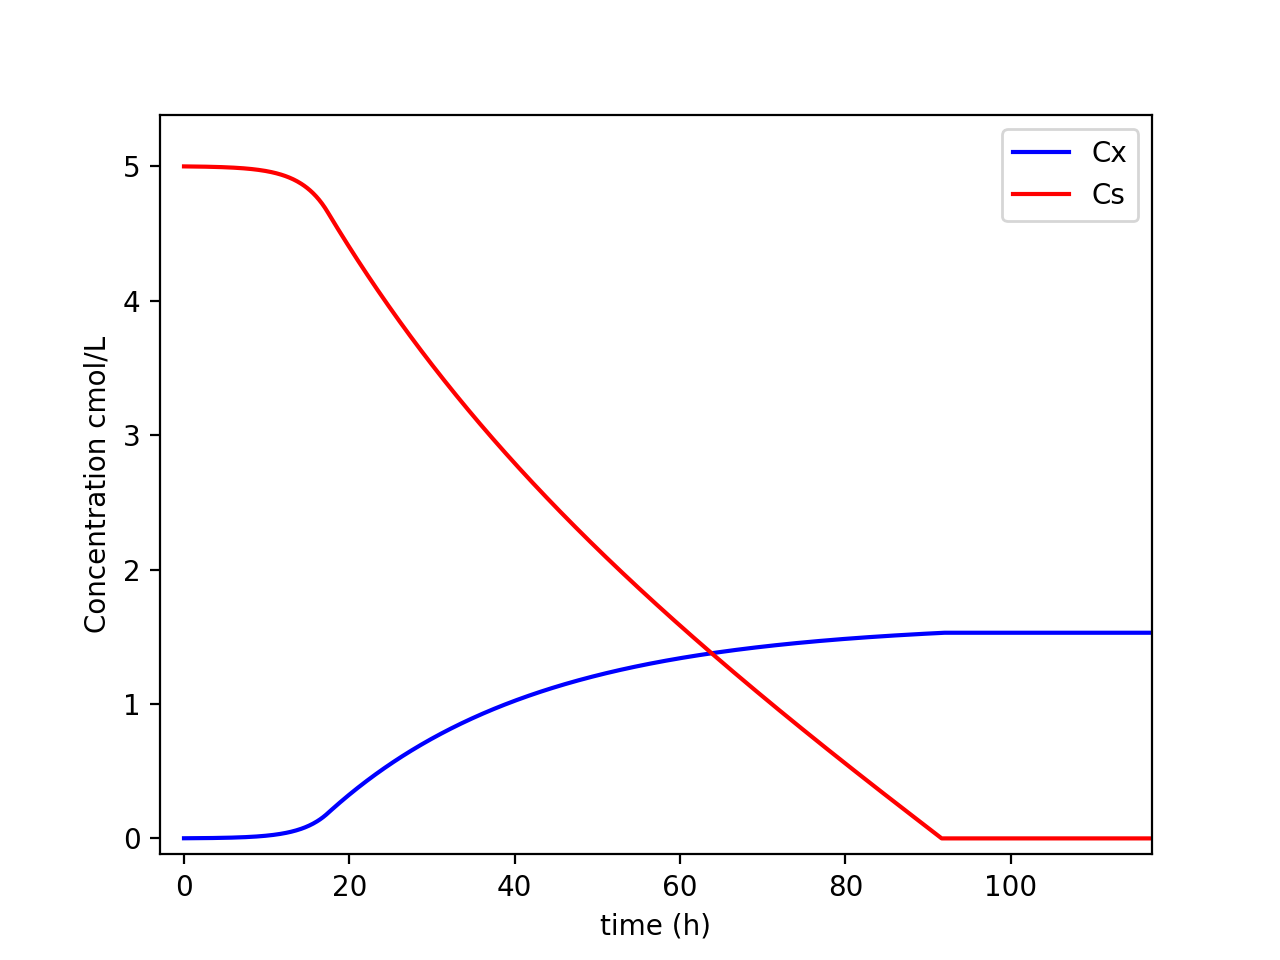

In [135]:
Co=[Cxo, Cso]                     # [Cxo, Cso, Cgo, Ceo] in cmol/L
tmax=120                                   # Integrate for 120 hours  
tspan=numpy.linspace(0,tmax,1000)           # define the timespan of the integration
Ci = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

Cx, Cs = Ci.T

plt.figure(2)
plt.plot(tspan, Cx, color='blue', label='Cx')
plt.plot(tspan, Cs, color='red', label='Cs')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.axis([0,120,0,5.5])
plt.show()

a) Determine $[\mu, -r_S, r_{O_2}]$ at 10, 30 and 90 hours. Explain the differences.

(Tip: redefine tspan with 121 elements so that the index corresponds to the time value)

In [136]:
ri = numpy.asarray([response_fun(C) for C in Ci])

for t in [10,30,90]:
    print(str(t)+" hours")
    for i,n in zip([0,1,3],["mu ", "rs ", "rO2 "]): #https://www.programiz.com/python-programming/methods/built-in/zip
        a=numpy.interp(t, tspan, ri[:,i])
        print(n+str(a))   

10 hours
mu 0.2999395829662383
rs -0.549439358418876
rO2 0.23450279630432586
30 hours
mu 0.04577632421916746
rs -0.10696385641407714
rO2 0.058898715983951314
90 hours
mu 0.002160172607676736
rs -0.03097565077521283
rO2 0.02870746953715226


Mu is decreasing as oxygen conc decrease.
rs consumption decreases over time, likely as the microbes begin to grow slower due to the decreased oxygen supply.
rO2 also decreases over time as the maximum is reached and the biomass continues to increase.

b) What is the minimum value of $r_{O_2}$ for a cell to survive? No integration required. $[0.0272 \frac{mol}{cmol \, X \cdot h}]$

(Tip: Copy the matrix from the response function, alter accordingly and solve the matrix manually (not using any functions).

In [137]:
def fprint(s, i=2):
    print(("{:."+str(i)+"f}").format(s))

Minimum oxygen pull is when mu=0 and theta is maximum.

In [138]:
def r02_min():
    S2 = numpy.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                      [0,0.1,1,0,-1],
                      [0,0.1,2,-2,0],
                      [0,-2.5,2/3,3,0],
                      [0,1,0,0,0]])

    C2 = numpy.matrix([[0,0,0,theta_max,0]]).T
    r2 = numpy.linalg.solve(S2,C2)
    return r2[3,0]

print(r02_min(),'cmol/(X.h)')
fprint(r02_min(),4)

0.027272727272727275 cmol/(X.h)
0.0273


c) Given the value in (b), that is the maximum possible $C_X$ that the fermenter can sustain. $[1.604 \frac{cmol}{L}]$

(Tip: $r_{O_2}^{mt}=r_{O_2}^V=r_{O_2}C_X$)

In [139]:
print((kla*Co_s_max)/r02_min())
fprint((kla*Co_s_max)/r02_min(),3)

1.6041666666666667
1.604


d) How does the answer in (c) compare to the final $C_X$ achieved in the fermentation? 

In [140]:
fprint(Cx[-1], 3)

1.530


The theoretical answer in c) is higher than the actual $C_x$ achieved. This is because there is insufficient glucose for the fermenter to reach the maximum $C_x$.

e) Play around by increasing $C_{S}^o$ and the fermentation time. Does the final $C_X$ get closer to the maximum value in (c)?

1.6040045344409761


<IPython.core.display.Javascript object>


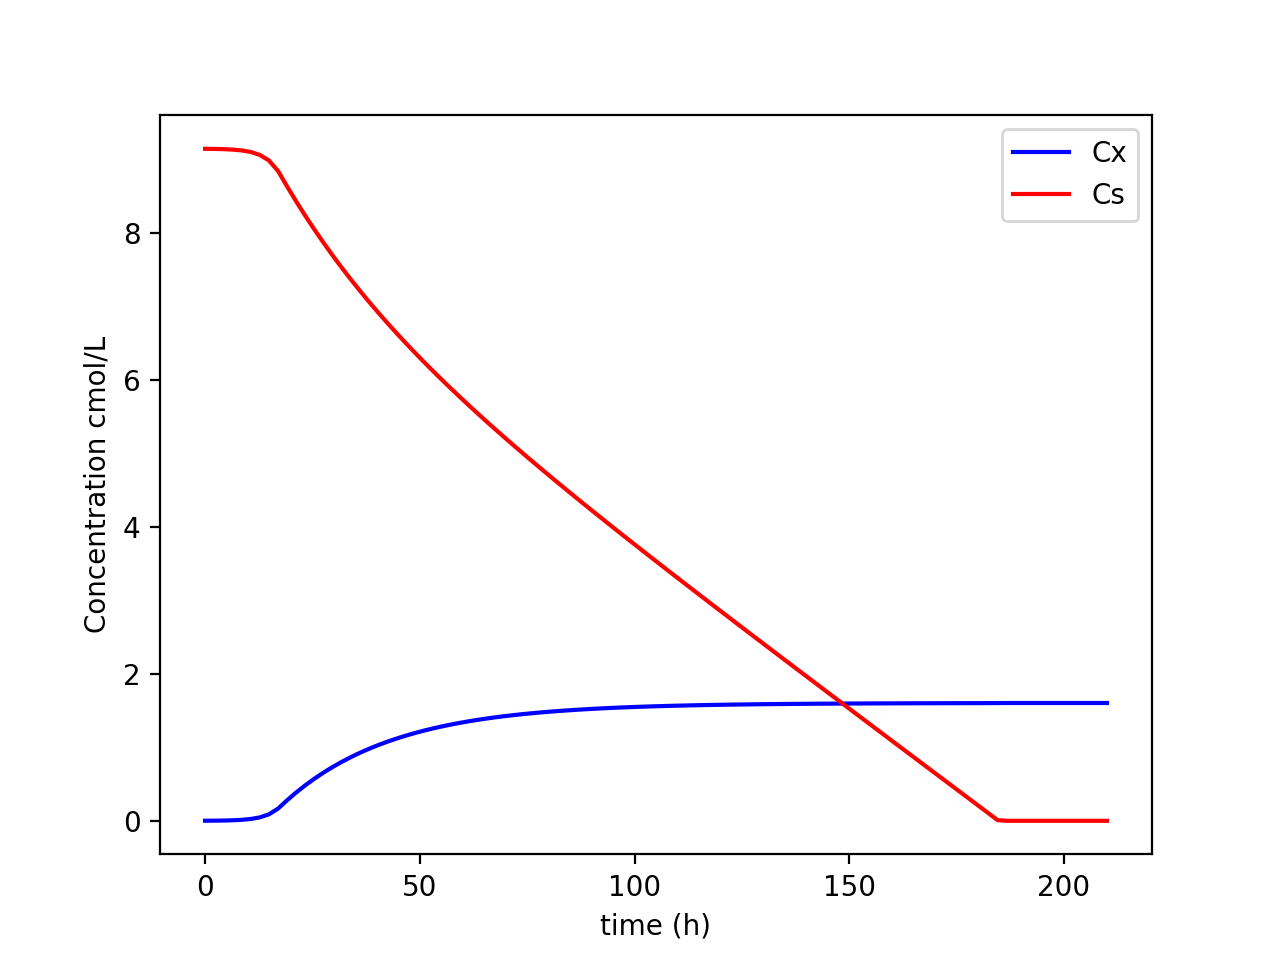

<IPython.core.display.Javascript object>


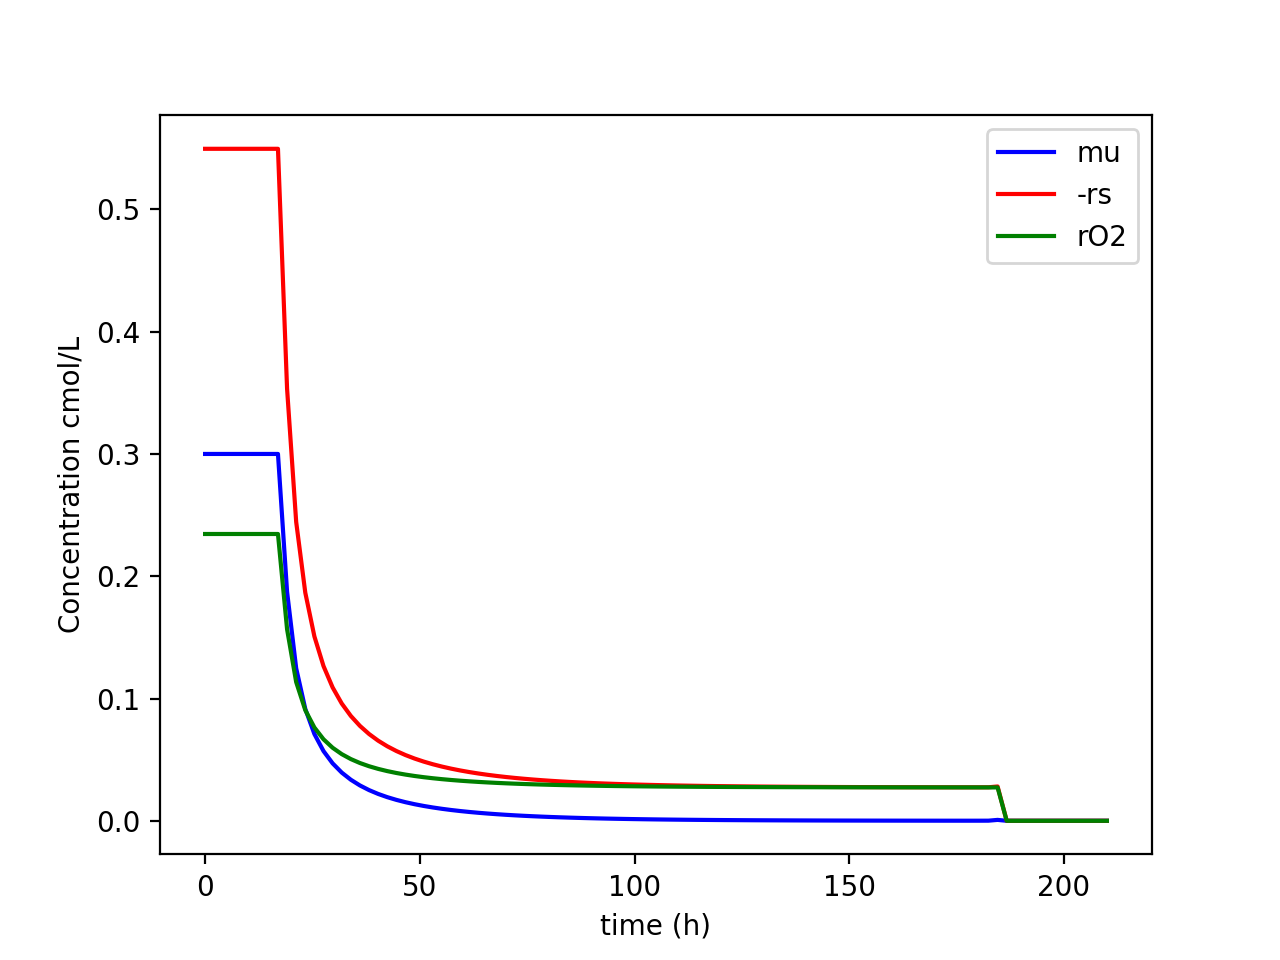

In [141]:
tmax_e=210 
tspan_e=numpy.linspace(0,tmax_e,100)
#Cs0_e=5 #get 1.530, used as a test to make sure it works
Cs0_e=9.15  # kept changing glucose value here to get to Cx_max in (c)
Ci_e = odeint(ferm_eq, [0.025/Mx, Cs0_e], tspan_e)
Cx_e=Ci_e[:,0]                                  
Cs_e=Ci_e[:,1]

ri_e=numpy.asarray([response_fun(C) for C in Ci_e])
    
print(Cx_e[-1])

plt.figure(4)
plt.plot(tspan_e, Cx_e, color='blue', label='Cx')
plt.plot(tspan_e, Cs_e, color='red', label='Cs')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()


plt.figure(5)
plt.plot(tspan_e, ri_e[:,0], color='blue', label='mu')
plt.plot(tspan_e, -ri_e[:,1], color='red', label='-rs')
plt.plot(tspan_e, ri_e[:,3], color='green', label='rO2')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.show()

f) At what point in time is the maximum volumetric supply of oxygen fully utilised? [approx 17 hours]

In [142]:
#https://stackoverflow.com/questions/5642457/how-does-python-numpy-where-work?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
print( tspan[numpy.where(kla*Co_s_max == ri[:,3]*Cx)[0][0]],'hours' )

17.41741741741742 hours


g) Plot $\mu$ as a function of time. Explain the profile.

<IPython.core.display.Javascript object>


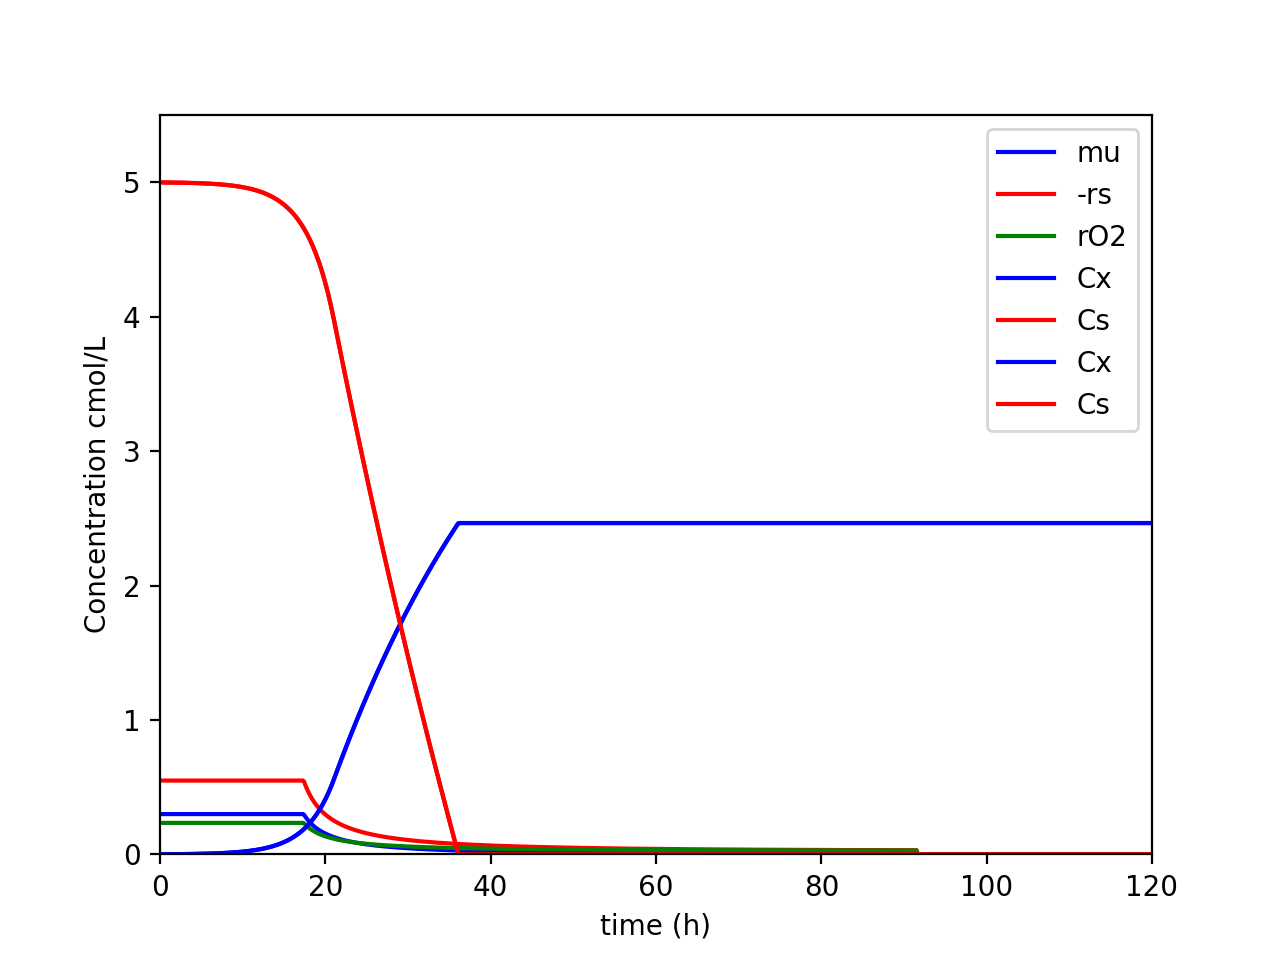

In [143]:
plt.figure(6)
plt.plot(tspan, ri[:,0], color='blue', label='mu')
plt.plot(tspan, -ri[:,1], color='red', label='-rs')
plt.plot(tspan, ri[:,3], color='green', label='rO2')
plt.legend(loc='best')
plt.ylabel('rate 1/h') 
plt.xlabel('time (h)') 
plt.axis([0,120,0,0.6])
plt.show()

As oxygen begins to decrease, mu decreases as well, which in turn reduces the pull on substrate.

h) Determine the fraction of glucose spent on growth at 18 and 80 hours. [94% and 17%]


In [144]:
def response_noGrow(C):
    
    Cx, Cs = C          
    mu=0
    theta=theta_max*Cs/(Km_theta+Cs)
    
    ro_mt=kla*Co_s_max
    
    Sbase = numpy.matrix([[-1,1.1,1,0,0],   #Stoichiometric matrix without specification (4x5)
                         [0,0.1,1,0,-1],
                         [0,0.1,2,-2,0],
                         [0,-2.5,2/3,3,0]])
    
    S1 = numpy.vstack([Sbase,[0,1,0,0,0]])  #Stoich matrix with growth spec
      
    C = numpy.matrix([[0,0,0,theta, mu]]).T
    r = numpy.linalg.solve(S1,C)            #rates for regime where no oxygen limitation exist
    
        
    if ro_mt > r[3,0]*Cx:     #no oxygen limitation
        
        return r[0,0]                                                     
     
    else:
        
        S2 = numpy.vstack([Sbase,[0,0,0,1,0]])          #Stoich matrix with oxygen spec

        C2 = numpy.matrix([[0,0,0,theta,ro_mt/Cx]]).T   # Note the ro specification!!
        r2 = numpy.linalg.solve(S2,C2)                 # rates for regime where oxygen limitation exist
        
        
        return r2[0,0]   

for t in [18, 80]:
    tn=numpy.where(abs(tspan -t )<1e-1)[0][0]
    rsg=-ri[:,1][tn]
    rsng=response_noGrow(Ci[tn])
    fprint( (1- rsng/rsg) * 100 )

#change the tspan spacing to 1000, then it works. Will bomb out if left at 200


94.01
16.92



i) Increase the value of $k_La$ to 600 $\frac{1}{h}$ an plot the results against the original profiles. Explain the difference.



<IPython.core.display.Javascript object>


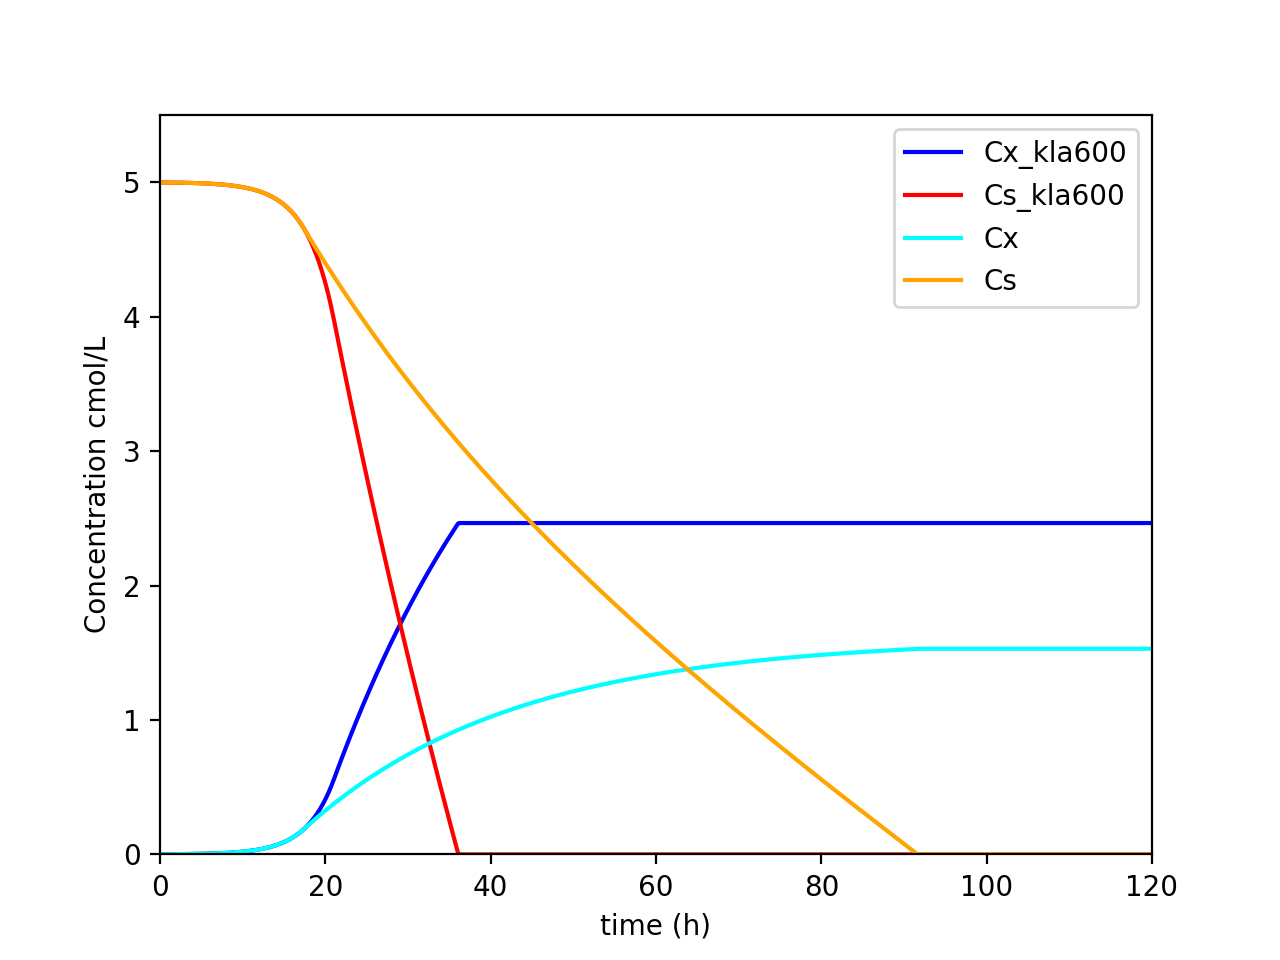

In [149]:
kla=600

Ci_i = odeint(ferm_eq, Co, tspan)             # integration via odeint that calls apon ferm_eq

kla=200

Cx_i=Ci_i[:,0]                                  
Cs_i=Ci_i[:,1]

plt.figure(7)
plt.plot(tspan, Cx_i, color='blue', label='Cx_kla600')
plt.plot(tspan, Cs_i, color='red', label='Cs_kla600')
plt.plot(tspan, Cx, color='cyan', label='Cx')
plt.plot(tspan, Cs, color='orange', label='Cs')
plt.legend(loc='best')
plt.ylabel('Concentration cmol/L') 
plt.xlabel('time (h)') 
plt.axis([0,120,0,5.5])
plt.show()

The fermentation happens much faster with a higher KLa, because the biomass can grow faster for longer due to there being more oxgyen avaliable for it.

[Back to all tutorials](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/Tutorials/All%20tutorials.ipynb)